In [1]:
import os
import neptune
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm as tqdm
from scipy.stats import ttest_ind as ttest,pearsonr
import scipy
import xarray as xr
from scipy.spatial.distance import pdist,squareform,cdist
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,KFold
from sklearn.cross_decomposition import CCA

# from tensorflow.python import keras as keras
from keras.models import Model

from src.results.experiments import _DateExperimentLoader
from src.results.utils import raw_to_xr, dprime
from src.results.neptune import get_model_files, load_models, load_assemblies, load_params, load_properties,prep_assemblies,NeptuneExperimentRun,generate_convnet_encoders
from src.results.dicarlo import get_dicarlo_su, process_dicarlo,err_neuroids,load_md_images
from src.results.metrics import cca
from src.data_loader import Shifted_Data_Loader
# from src.data_generator import ShiftedDataBatcher
import src.rcca

import brainscore
from brainscore.assemblies import walk_coords,split_assembly
from brainscore.assemblies import split_assembly
# from brainscore.metrics import Score

from brainio_base.assemblies import DataAssembly

def set_style():
    # This sets reasonable defaults for font size for
    # a figure that will go in a paper
    sns.set_context("talk")
    
    # Set the font to be serif, rather than sans
    sns.set(font='serif')
    
    # Make the background white, and specify the
    # specific font family
    sns.set_style("white", {
        "font.family": "serif",
        "font.serif": ["Georgia","Times New Roman", "Palatino", "serif"]
    })

Using TensorFlow backend.


In [2]:
os.environ['NEPTUNE_API_TOKEN']="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vdWkubmVwdHVuZS5tbCIsImFwaV9rZXkiOiI3ZWExMTlmYS02ZTE2LTQ4ZTktOGMxMi0wMDJiZTljOWYyNDUifQ=="
neptune.init('elijahc/DuplexAE')
neptune.set_project('elijahc/DuplexAE')
proj_root = '/home/elijahc/projects/vae'

In [3]:
from src.results.neptune import load_configs

In [4]:
lg_conv = [
#     'DPX-45',
    'DPX-64',
    'DPX-65',
    'DPX-66',
    
]

In [5]:
# lg_conv = [
#     'DPX-45',
#     'DPX-59',
#     'DPX-61'
    
# ]

In [6]:
conv_eids = [
    'DPX-29',
    'DPX-30',
]
dense_eids = [
    'DPX-10',
    'DPX-16',
#     'DPX-27',
]
# eids = conv_eids+dense_eids
lg_conv_exps = neptune.project.get_experiments(id=lg_conv)
conv_exps = neptune.project.get_experiments(id=conv_eids)
dense_exps = neptune.project.get_experiments(id=dense_eids)
exps = np.array(lg_conv_exps+dense_exps)
s_df = pd.DataFrame(list(load_configs(exps)))
s_df.head()

,assembly_fn,augmentation,batch_sz,bg,bg_contrast,dataset,dir,encoder_arch,generator_arch,id,im_translation,n_epochs,recon_weight,rotation,su_selectivity_fn,xent_weight,y_dim,z_dim
0,NaN,dynamic,256.0,natural,0.5,fashion_mnist,models/2020-05-28/DPX-64,convnet,resnet,DPX-64,0.75,90000.0,1.0,0.3,NaN,15.0,500,0
1,NaN,dynamic,256.0,natural,0.5,fashion_mnist,models/2020-05-28/DPX-65,convnet,N/A,DPX-65,0.75,180000.0,0.0,0.3,NaN,15.0,500,0
2,NaN,dynamic,256.0,natural,0.5,fashion_mnist,models/2020-10-13/DPX-66,convnet,N/A,DPX-66,0.75,180000.0,15.0,0.3,NaN,0.0,500,0
3,dataset.nc,dynamic,512.0,natural,0.3,fashion_mnist,models/2019-09-25/DPX-10,dense,resnet,DPX-10,0.75,54000.0,1.0,NaN,selectivity.pqt,15.0,35,35
4,NaN,dynamic,512.0,natural,0.3,fashion_mnist,models/2019-09-25/DPX-16,dense,resnet,DPX-16,0.75,54000.0,0.0,NaN,NaN,15.0,35,35


In [7]:
from sklearn.linear_model import Lasso,LassoCV,MultiTaskLassoCV,MultiTaskLasso,SGDRegressor
from sklearn.svm import SVR,LinearSVR,NuSVR

In [8]:
neural_data = brainscore.get_assembly(name="dicarlo.Majaj2015")
neural_data.load()
stimulus_set = neural_data.attrs['stimulus_set']
# # stimulus_set.to_csv('../data/dicarlo_images/stimulus_set.csv',index=False)
neural_data = process_dicarlo(neural_data)

/home/elijahc/.pyenv/versions/fastai/lib/python3.6/site-packages/brainio_base/assemblies.py:213: FutureWarning: The inplace argument has been deprecated and will be removed in a future version of xarray.
  xr_data.set_index(append=True, inplace=True, **coords_d)
/home/elijahc/.pyenv/versions/fastai/lib/python3.6/site-packages/brainio_base/assemblies.py:247: FutureWarning: The inplace argument has been deprecated and will be removed in a future version of xarray.
  result.reset_index(self.multi_group_name, drop=True, inplace=True)
/home/elijahc/.pyenv/versions/fastai/lib/python3.6/site-packages/brainio_base/assemblies.py:248: FutureWarning: The inplace argument has been deprecated and will be removed in a future version of xarray.
  result.set_index(append=True, inplace=True, **{self.multi_group_name: self.group_coord_names})


In [9]:
med_images = load_md_images(proj_root)

In [10]:
# sm_imgs = np.load('../data/dicarlo_images/sm_imgs_56x56.npy')

# ids3 = stimulus_set[stimulus_set.variation.values==3].image_id.values
# sm_ims = list(zip(ids3,sm_imgs[stimulus_set.variation.values==3]))

# Xm,Xs = (sm_imgs.mean(),sm_imgs.std())
# scaled_sm_imgs = np.clip((sm_imgs-Xm)/Xs,-1,1)

In [11]:
dicarlo_metadata = stimulus_set[['image_id','object_name','category_name','variation','dy_px','dx_px','rxy']].rename(columns={'dx_px':'dx','dy_px':'dy'})
dicarlo_metadata = {k:list(v.values()) for k,v in dicarlo_metadata.to_dict().items()}
# metadata

In [12]:
pd.DataFrame.from_records(dicarlo_metadata).head()

,category_name,dx,dy,image_id,object_name,rxy,variation
0,Cars,0.0,0.0,8a72e2bfdb8c267b57232bf96f069374d5b21832,car_astra,-0.0,0
1,Tables,0.0,0.0,27f69468c9d6019ed0d22b9583c94c5b58198c1c,table3,-0.0,0
2,Faces,0.0,0.0,6af1cbb28aacea6c582faa07e92d8325fa7a29d7,face2,-0.0,0
3,Fruits,0.0,0.0,d0f7a45b377d4920c3466ec7a20dce9437a150d6,walnut,-0.0,0
4,Fruits,0.0,0.0,d4c3b4d4aefd29fd168a2c3c9a9962d99653a715,walnut,-0.0,0


In [13]:
# dfs = []
# for exp,name in zip(reversed(exps),['no-recon','w/ recon','w/ recon','no-recon']):
#     run = NeptuneExperimentRun(proj_root,neptune_exp=exp)
#     xrs = run.gen_assembly(scaled_sm_imgs, n_units=180, **metadata)
#     lasso_df = lasso(xrs,neural_data,region=None,variation=[0,3],cv=2)
#     lasso_df['model']= name
#     lasso_df['arch']=run.get_config()['encoder_arch']
#     dfs.append(lasso_df)

# lasso_3 = pd.concat(dfs)

In [14]:
# obj = ['no-recon','w/ recon','w/ recon','no-recon']
# att = []
# for exp,o in zip(exps,obj):
#     run = NeptuneExperimentRun(proj_root,neptune_exp=exp)
#     xr,pcas = run.pca_assembly(scaled_sm_imgs, n_units=None, n_components=0.8, metadata=metadata, pca_kws={'svd_solver':'full'})
#     att.append(pcas)

In [15]:
# pca_dfs = []
# recs = []
# for mod,o in zip(att,obj):
#     for k,v in mod.items():
#         df = pd.DataFrame.from_records({'fve':v.explained_variance_,
#                                         'fve_ratio':v.explained_variance_ratio_,
#                                         'component':np.arange(len(v.explained_variance_))})
#         df['arch'] = k[:4]
#         df['depth'] = int(k[-1:])
#         df['layer']=k
#         df['objective']=o
#         pca_dfs.append(df)
# pca_80 = pd.concat(pca_dfs)

In [16]:
# pca_80['cum_fve'] = pca_80.groupby(['arch','objective','layer'])['fve_ratio'].transform('cumsum')


In [17]:
# pca_80.to_pickle('../data/cca/pca_80fve.pk')

In [18]:
# sns.set_context('talk')
# g = sns.FacetGrid(data=pca_80,row='objective',col='arch',hue='depth',sharex='col',margin_titles=True,
#                   ylim=(0,1),
#                   height=4, palette='plasma',legend_out=True,
#                  )
# # plt.xscale('log')
# g.map(sns.lineplot,'component','cum_fve').add_legend()
# for a in g.axes.ravel():
#     pass
# #     a.set_xscale('log')
# # g.map(plt.hlines,y=0.8,xmin=0,xmax=600,colors='k',linestyle='dashed')

# # sns.lineplot(x='index'y='fve_ratio',hue='')

In [19]:
# count_pca_80 = pca_80.groupby(['arch','objective','layer'])['fve'].count().reset_index().rename(columns={'fve':'n_components'})

In [20]:
# g = sns.FacetGrid(data=count_pca_80,col='arch',row='objective',sharex='col',sharey=False,margin_titles=True,
# #                   ylim=(0,1),
#                   height=4, palette='plasma',legend_out=True,
#                  )
# # plt.xscale('log')
# g.map(plt.bar,'layer','n_components')
# g.fig.autofmt_xdate(rotation=45)

### Inspired by [BrainScore](https://www.biorxiv.org/content/10.1101/407007v1.full), we do PCA on whole layer activations and PLS/CCA on the PCA components

In [21]:
run = NeptuneExperimentRun(proj_root,lg_conv_exps[0])

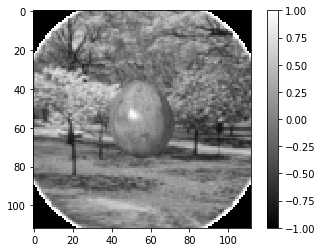

In [22]:
plt.imshow(med_images[3],cmap='gray')
plt.colorbar()

In [23]:
dfs = []
obj = ['full','classify only','recon only']
# obj = ['recon only']

for exp,obj in zip(lg_conv_exps[-1:], obj[-1:]):
    run = NeptuneExperimentRun(proj_root,neptune_exp=exp)
    for k in np.arange(5):
    #         xr = next(run.load_assemblies(filenames=['dicarlo.{}.nc'.format(run.name)]))
        xr = run.gen_assembly(med_images, n_units=250, metadata=dicarlo_metadata)

        cca_df = cca(xr,neural_data[:,~neural_data.neuroid_id.isin(err_neuroids)],
                     variation=[0,3,6],cv=3, n_components=10,
                     region=None,brain_region=['IT','V4'],sortby='image_id')
        cca_df['objective']= obj
        cca_df['arch']=run.get_config()['encoder_arch']
        cca_df['cross_validation']=k+1
        dfs.append(cca_df)
    
cca_300_unit_10_component_036_112 = pd.concat(dfs)

cca_300_unit_10_component_036_112.head()

building model DPX-66(arch=convnet, recon=15.0)...
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Compiling model
Instructions for updating:
keep_dims is deprecated, use keepdims instead
generating convolutional activations...


conv_1(5760, 250) x V4(5760, 88):  33%|███▎      | 1/3 [00:01<00:03,  1.53s/it, cca=0.155, fve=-.254, pearson=0.245]/home/elijahc/.pyenv/versions/fastai/lib/python3.6/site-packages/sklearn/cross_decomposition/pls_.py:79: ConvergenceWarning: Maximum number of iterations reached
  ConvergenceWarning)
y_enc(5760, 250) x V4(5760, 88): 100%|██████████| 3/3 [00:04<00:00,  1.61s/it, cca=0.242, fve=0.0849, pearson=0.379]


generating convolutional activations...


y_enc(5760, 250) x V4(5760, 88): 100%|██████████| 3/3 [00:04<00:00,  1.57s/it, cca=0.238, fve=0.0749, pearson=0.369]


generating convolutional activations...


y_enc(5760, 250) x V4(5760, 88): 100%|██████████| 3/3 [00:04<00:00,  1.66s/it, cca=0.241, fve=0.0712, pearson=0.372]


generating convolutional activations...


y_enc(5760, 250) x IT(5760, 168):  33%|███▎      | 1/3 [00:02<00:04,  2.16s/it, cca=0.262, fve=0.0448, pearson=0.274]/home/elijahc/.pyenv/versions/fastai/lib/python3.6/site-packages/sklearn/cross_decomposition/pls_.py:79: ConvergenceWarning: Maximum number of iterations reached
  ConvergenceWarning)
y_enc(5760, 250) x V4(5760, 88): 100%|██████████| 3/3 [00:05<00:00,  1.66s/it, cca=0.237, fve=0.0596, pearson=0.362]


generating convolutional activations...


y_enc(5760, 250) x V4(5760, 88): 100%|██████████| 3/3 [00:04<00:00,  1.56s/it, cca=0.237, fve=0.07, pearson=0.363]  


,cca_r,depth,fve,iter,layer,neuroid_id,pearsonr,region,objective,arch,cross_validation
0,0.188021,1,-0.033878,0,conv_1,Chabo_L_M_5_9,0.238836,IT,recon only,convnet,1
1,0.188021,1,-0.115957,0,conv_1,Chabo_L_M_6_9,0.275893,IT,recon only,convnet,1
2,0.188021,1,-0.032385,0,conv_1,Chabo_L_M_5_8,0.148698,IT,recon only,convnet,1
3,0.188021,1,-0.152389,0,conv_1,Chabo_L_M_7_9,0.192476,IT,recon only,convnet,1
4,0.188021,1,-0.039255,0,conv_1,Chabo_L_M_6_8,0.162675,IT,recon only,convnet,1


In [24]:
asdf

NameError: name 'asdf' is not defined

In [25]:
cca_300_unit_10_component_036_112

,cca_r,depth,fve,iter,layer,neuroid_id,pearsonr,region,objective,arch,cross_validation
0,0.188021,1,-0.033878,0,conv_1,Chabo_L_M_5_9,0.238836,IT,recon only,convnet,1
1,0.188021,1,-0.115957,0,conv_1,Chabo_L_M_6_9,0.275893,IT,recon only,convnet,1
2,0.188021,1,-0.032385,0,conv_1,Chabo_L_M_5_8,0.148698,IT,recon only,convnet,1
3,0.188021,1,-0.152389,0,conv_1,Chabo_L_M_7_9,0.192476,IT,recon only,convnet,1
4,0.188021,1,-0.039255,0,conv_1,Chabo_L_M_6_8,0.162675,IT,recon only,convnet,1
5,0.188021,1,-0.056438,0,conv_1,Chabo_L_M_7_8,0.133743,IT,recon only,convnet,1
6,0.188021,1,-0.100838,0,conv_1,Chabo_L_M_9_7,0.162248,IT,recon only,convnet,1
7,0.188021,1,-0.037182,0,conv_1,Chabo_L_M_7_7,0.182694,IT,recon only,convnet,1
8,0.188021,1,-0.129275,0,conv_1,Chabo_L_M_9_5,0.124259,IT,recon only,convnet,1
9,0.188021,1,-0.080505,0,conv_1,Chabo_L_M_8_6,0.115425,IT,recon only,convnet,1


In [ ]:
# cca_300_unit_10_component_036_112.to_pickle('../data/cca/redo.cca_250unit_10component_112.pk')


In [28]:
# load original
cca_old = pd.read_pickle('../data/cca/redo.cca_250unit_10component_112.pk')


In [30]:
cca_old.objective = cca_old.objective.replace({'full recon':'combined','no recon':'classify'})

### cca_results_data

- #### objective
    > objective used to train the model
    > options are full recon, no recon

- #### arch
    > not really used, kept for backwards compatibility

- #### neuroid_id
    > neuroid_id from dicarlo ephys dataset that we attempt to predict
    
- #### pearsonr
    > pearson correlation coeficient between the predicted and actual responses to neuroid_id to set of test images

- #### fve
    > fraction of variance explained between the predicted and actual responses of neuroid_id to set of test images

- #### depth, layer
    > layer depth in the model from 1 (pixels) to 7 (y_enc)

- #### cca_r
    > cca

In [33]:
merge = pd.concat([cca_300_unit_10_component_036_112,cca_old])

In [ ]:
# cca_250_unit_10_component_036_112.to_pickle('../data/cca/lg_models_300unit_10_component.pk')

In [ ]:
# sns.set_context('talk')
# g = sns.catplot(x='objective',y='pearsonr',hue='layer',row='region',kind='violin',row_order=['IT','V4'],order=['no recon','sm recon','full recon'],
#                 data=cca_250_unit_10_component_036_112,sharey='row',aspect=3,palette='magma',height=4)

In [ ]:
# sns.set_context('talk')
# g = sns.FacetGrid(col='region', hue='objective', data=cca_250_unit_10_component_036_112,height=4,sharex=False,sharey='row',margin_titles=True)
# g.map(sns.lineplot,'layer','pearsonr').add_legend()
# g.fig.autofmt_xdate(rotation=45)

In [ ]:
dfs = []

pca_comps = [300, 300, 300]
obj = ['sm-recon','full-recon','no-recon']

for exp,n_c,obj in zip(lg_conv_exps,pca_comps[:3], obj[:3]):
    run = NeptuneExperimentRun(proj_root,neptune_exp=exp)
    xr,pca_objs = run.pca_assembly(med_images, n_units=None, n_components=300, metadata=dicarlo_metadata)
    
    cca_df = cca(xr,neural_data[:,~neural_data.neuroid_id.isin(err_neuroids)],
                 variation=[0,3,6],cv=6, n_components=10,
                 region=None,brain_region=['IT','V4'],sortby='image_id')
    cca_df['objective']= obj
    cca_df['arch']=run.get_config()['encoder_arch']
    dfs.append(cca_df)

pca_cca_nc_1 = pd.concat(dfs)


In [ ]:
pca_cca_nc_1.to_pickle('../data/cca/cca(1_component)_w_pca.pk')


In [ ]:
pca_cca_nc_1.head()


In [ ]:
dfs = []

pca_comps = [500, 250, 100, 100]
obj = ['no-recon','w/ recon','w/ recon','no-recon']

for exp,n_c,obj in zip(exps,pca_comps, obj):
    run = NeptuneExperimentRun(proj_root,neptune_exp=exp)
    xr,pca_objs = run.pca_assembly(scaled_sm_imgs, n_units=None, n_components=0.8, metadata=metadata)
    
    cca_df = cca(xr,neural_data[:,~neural_data.neuroid_id.isin(err_neuroids)],
                 variation=[0,3],cv=6, n_components=5,
                 region=None,brain_region=['IT','V4'],sortby='image_id')
    cca_df['objective']= obj
    cca_df['arch']=run.get_config()['encoder_arch']
    dfs.append(cca_df)

pca_cca_nc_5 = pd.concat(dfs)

In [ ]:
pca_cca_nc_5.head()

In [ ]:
pca_cca_nc_5.to_pickle('../data/cca/cca_5_component_w_pca.pk')

In [ ]:
dfs = []

pca_comps = [500, 250, 100, 100]
obj = ['no-recon','w/ recon','w/ recon','no-recon']

for exp,n_c,obj in zip(exps,pca_comps, obj):
    run = NeptuneExperimentRun(proj_root,neptune_exp=exp)
    xr,pca_objs = run.pca_assembly(scaled_sm_imgs, n_units=None, n_components=n_c, metadata=metadata)
    
    cca_df = cca(xr,neural_data[:,~neural_data.neuroid_id.isin(err_neuroids)],
                 variation=[0,3],cv=6, n_components=10,
                 region=None,brain_region=['IT','V4'],sortby='image_id')
    cca_df['objective']= obj
    cca_df['arch']=run.get_config()['encoder_arch']
    dfs.append(cca_df)

pca_cca_nc_5 = pd.concat(dfs)

In [ ]:
pca_cca_nc_10 = pd.concat(dfs)

In [ ]:
from sklearn.metrics import explained_variance_score

In [ ]:
pca_avg = pca_cca_nc_1.groupby(['arch','objective','layer','depth','region','neuroid_id']).mean().reset_index()

In [ ]:
pca_cca_nc_1.to_pickle('../data/cca/lg_300pca_10cca.pk')

In [ ]:
len(cca_300_unit_10_component_036_112[['objective','cca_r','layer','region']])

In [ ]:
sns.boxplot()

In [34]:
merge.objective = merge.objective.replace({'recon only':'recon'})

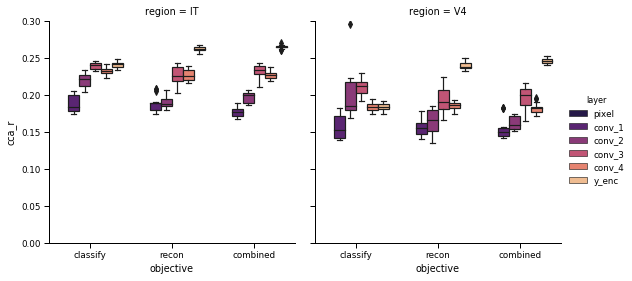

In [42]:
sns.set_context('paper')

cca_r_dat = merge[['objective','cca_r','layer','region']].drop_duplicates()

g = sns.catplot(x='objective',y='cca_r',hue='layer',col='region', kind='box',col_order=['IT','V4'],
                order=['classify','recon','combined'],
#                 cut=0,bw=0.3,
                data=cca_r_dat,sharey=True,aspect=1.0,palette='magma',height=4,dodge=True,orient='v',
                hue_order=['pixel','conv_1','conv_2','conv_3','conv_4','y_enc'],facet_kws={'margin_titles':True,'ylim':(0,0.3)}
               )

sns.despine(g.fig)

In [43]:
g.fig.savefig('../figures/pub/neural_networks_revision/cca.pdf',dpi=200)

In [ ]:
sns.set_context('talk')
g = sns.catplot(x='objective',y='pearsonr',hue='layer',col='region',kind='violin',col_order=['IT','V4'],
                order=['no-recon','sm-recon','full-recon'],cut=0,bw=0.3,
                data=pca_avg,sharey=False,aspect=2,palette='magma',height=7,dodge=True,orient='v',
                hue_order=['conv_1','conv_2','conv_3','conv_4','y_enc'],facet_kws={'margin_titles':True}
               )

In [ ]:
sns.pointplot()

In [ ]:
cca_300_unit_10_component_036_112.head()

In [ ]:
sns.set_context('talk')
g = sns.catplot(x='layer',y='cca_r',kind='point',col='region',hue_order=['no recon','full recon'],
                data=cca_300_unit_10_component_036_112, aspect=1,palette='magma',hue='objective',dodge=True,join=True,height=7,
                order=['conv_1','conv_2','conv_3','conv_4','y_enc'],
               )

In [ ]:
sns.set_context('talk')
g = sns.catplot(y='layer',x='fve',kind='point',col='region',hue_order=['no-recon','sm-recon','full-recon'],
                data=pca_avg,aspect=1,palette='magma',hue='objective',dodge=True,join=True,height=7,
                order=reversed(['conv_1','conv_2','conv_3','conv_4','y_enc']),
               )

In [ ]:
sns.set_context('talk')
g = sns.FacetGrid(col='region',hue='objective', hue_order=['no-recon', 'sm-recon','full-recon'], data=pca_cca_nc_1,height=4,sharex=False,sharey=False,margin_titles=True)
g.map(sns.lineplot,'layer','pearsonr').add_legend()
g.fig.autofmt_xdate(rotation=45)

In [ ]:
sns.set_context('talk')
g = sns.FacetGrid(col='arch',row='region', hue='objective', data=pca_cca_nc_5,height=4,sharex=False,sharey='row',margin_titles=True)
g.map(sns.lineplot,'layer','fve').add_legend()
g.fig.autofmt_xdate(rotation=45)

In [ ]:
g.fig.savefig('../figures/cca/pca_cca5_fve.png',dpi=150)

In [ ]:
sns.set_context('talk')
g = sns.FacetGrid(col='arch',row='region', hue='objective', data=pca_cca_nc_5,height=4,sharex=False,sharey='row',margin_titles=True)
g.map(sns.lineplot,'layer','pearsonr').add_legend()
g.fig.autofmt_xdate(rotation=45)

In [ ]:
sns.boxplot()

In [ ]:
cca_3.head()

In [ ]:
sns.set_context('talk')
g = sns.FacetGrid(col='arch',row='region',hue='model', data=cca_3,height=5,sharex=False,palette='viridis')
g.map(sns.boxenplot,'layer','pearsonr').add_legend()
g.fig.autofmt_xdate(rotation=45)

In [ ]:
sns.boxenplot(x='depth',y='fve',hue='model',data=cca_3.query('arch == "dense"'))

In [ ]:
sns.lineplot(x='layer',y='pearsonr',style='model',hue='region',
#                  data=conv_cca.query('{} == "{}"'.format(split_on,col)),
             data=cca_3.query('region == "IT"'),)
    
plt.xticks(rotation=45)

In [ ]:
cca_df_all = cca(xrs,neural_data,variation=[0,3,6],cv=35,region=['conv_1','conv_2','conv_3','conv_4','y_enc','z_enc'],sortby='image_id')

In [ ]:
sns.set_context('talk')
cca_df_all['model']='no-recon'
cca_df['model'] = 'no-recon'
g = sns.FacetGrid(col='region',row='model',data=cca_df,height=5)
g.map(sns.stripplot,'layer','pearsonr')
g.fig.autofmt_xdate(rotation=45)

In [ ]:
sns.lineplot(x='layer',y='pearsonr',style='model',hue='region',
#                  data=conv_cca.query('{} == "{}"'.format(split_on,col)),
             data=cca_df,)
    
plt.xticks(rotation=45)

In [ ]:
import src.rcca as rcca
from sklearn.cross_decomposition import CCA

def dicarlo_cca(data,stimulus_set,region,variation=[3],cv=10):
    
    
#     print(data.image_id.values)
#     print(nd.image_id.values)
    
    print('same order? \t',list(data.sortby('image_id').image_id.values) == list(nd.sortby('image_id').image_id.values))
    
    print('model.shape\t',data.shape)
    print('dicarlo.shape\t',nd.shape)
    out_dict = {'region':[],
#                 'variation':[],
#                 'rdm':[],
                'layer':[],
                'pearsonr':[],
                'p-value':[],
                'iter':[],
               }
    xrs = []
    ab_vectors = []
    ccas = []
        
    cv_tr = []
    cv_te = []
    
    num_images = data.shape[0]
    print(num_images)
    
    for rand_delta in np.arange(cv):
        tr_idx, te_idx, _,_ = train_test_split(np.arange(num_images),np.arange(num_images),train_size=0.75,random_state=np.random.randint(0,50)+rand_delta)
        cv_tr.append(tr_idx)
        cv_te.append(te_idx)
        
    for reg in region:
        sub_dat = data.sel(region=reg)
#         print(sub_dat)
        
        for brain_region in ['V4','IT']:
            
            pairing = '{} x {}'.format(reg,brain_region)
            for n, tr,te in tqdm(zip(np.arange(cv),cv_tr,cv_te),total=cv,desc=pairing):
                cca = CCA(n_components=1)
                cca.fit(sub_dat.values[tr],nd.sel(region=brain_region).values[tr])
            
                ab_vec = cca.transform(sub_dat.values[te],nd.sel(region=brain_region).values[te])
        
                r,pv = pearsonr(ab_vec[0],ab_vec[1])

                out_dict['region'].append(brain_region)
                out_dict['layer'].append(reg)
                out_dict['pearsonr'].append(r[0])
                out_dict['p-value'].append(pv[0])
                out_dict['iter'].append(n)
            
#             print(out_dict)
        
#         ccas.append(cca)
        
#         cca_score = r
        
#         cca_score = cca.score(sub_dat.values,nd.sel(region='IT').values)
        
#         cca = CCA(kernelcca = False, reg = 0.001, numCC = 2)
    
#         X_tr, X_te, y_tr, y_te = train_test_split(np.arange(2560),np.arange(2560))
        
#         data_vecs = [sub_dat.values,sub_dat.values,nd.sel(region='IT').values,nd.sel(region='IT').values]
        
#         idxs = [X_tr, X_te, y_tr, y_te]
        
#         X_tr,X_te, y_tr, y_te = tuple([d[idx] for d,idx in zip(data_vecs,idxs)])
        
# #         ,nd.sel(region='IT').values
        
#         print(X_tr.shape,y_tr.shape)
#         print(X_te.shape,y_te.shape)
        
#         cca.train([X_tr,y_tr])
        
#         cca_score = cca.validate([X_te,y_te])
#         print([t.shape for t in cca_score])

#         xrs.append(cca_score)
        
    return out_dict
        